In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('..')
from utils import input_parse

In [119]:
import matplotlib; mpl =matplotlib
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize'] = (12.0,9.0) # default = (6.0, 4.0)
mpl.rcParams['font.size']      = 24        # default = 10

mpl.rcParams['axes.linewidth']    = 0.75 # default = 1.0
mpl.rcParams['lines.linewidth']   = 1.5 # default = 1.0
mpl.rcParams['patch.linewidth']   = 1.0 # default = 1.0
mpl.rcParams['grid.linewidth']    = 0.5 # default = 0.5
mpl.rcParams['xtick.major.width'] = 1.0 # default = 0.5
mpl.rcParams['xtick.minor.width'] = 0.0 # default = 0.5
mpl.rcParams['ytick.major.width'] = 1.0 # default = 0.5
mpl.rcParams['ytick.minor.width'] = 0.0 # default = 0.5

colors = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec'];

def make_nice_axis(ax):
    """ Function to beautify axis"""

    ax.spines['top'].set_visible(False) # hide top axs
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_position(('outward', 30))
    ax.spines['left'].set_position(('outward', 30))
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_tick_params(pad=10)
    ax.yaxis.set_tick_params(pad=10)
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)
    ax.xaxis.labelpad = 10
    ax.yaxis.labelpad = 20
    
# def plotly_beautify(plotly_fig):
#     plotly_fig['layout']['xaxis1']['showline'] = True
#     plotly_fig['layout']['yaxis1']['showline'] = True
#     plotly_fig['layout']['xaxis1']['showgrid'] = True
#     plotly_fig['layout']['yaxis1']['showgrid'] = True
#     plotly_fig['layout']['showlegend'] = True

def key_func(x,extension='.npy'):
    """
    Input   =   List of PNG image file paths (x)
    Output  =   List of filenames without extensions (to sort)
    """
    return int(x.split('-')[-1].rstrip(extension))


In [120]:
def input_parse(filename,params_flag=False):
    """
    Parses input files (filename is path to input parameters or param_list file)
    params_flag toggles between input_params vs param_list
    """

    input_parameters  ={};
    with open(filename, 'r') as f:
        count = 0;

        for line in f:
            line=line.strip();
            if line.find('None') ==-1 and line.find('wJ') ==-1:
                if line.find('[') ==-1:
                    var_name,var_value = line.split(',');
                    input_parameters[var_name] = float(var_value);
                else:
                    
                    if line.find(',')>-1:
                        var_name,var_value = line.split(',');
                    else:
                        var_name = '['
                        var_value = line;
                    if var_name.find('[')==-1:
                        v = var_name;
                        input_parameters[v] = [];
                        input_parameters[v].append(np.array(var_value)); 
                    else:
                        input_parameters[v].append(np.array(var_value))
                            

    return input_parameters;

## Analyse simulation data

In [121]:
class Analyses:
    
    def __init__(self,ofol):
        self.ofolder = ofol;
        self.ofiles =  os.listdir(self.ofolder);
        self.trajfol = [];
        for f in self.ofiles:
            self.trajfol.append(self.ofolder+'/' + f + '/')
    
    def mesh_data(self):
        self.mesh_data ={};
        for traj in self.trajfol:
            self.mesh_data[traj] = {};
            mesh_files = sorted(os.listdir(traj+'Mesh/'),key=key_func);
            for m in mesh_files:
                self.mesh_data[traj][m.split('-')[-1].rstrip('.npy')]=(np.load(traj+'Mesh/'+m))
                
    def load_params(self):
        self.params = {};
        for traj in self.trajfol:
            param_file = traj+'all_params.txt'
            self.params[traj] = input_parse(traj+'all_params.txt')

In [135]:
class free_energy():
    
    def __init__(self,c0,chi,chis):
        self.c0 = c0;
        self.NCom = c0.shape[0];
        self.chi = chi;
        self.chis = chis;
        self.cs = 1- np.sum(c0);
        
    def f(self,c):
        f = np.sum(c*np.log(c)) + np.linalg.multi_dot((c.T,self.chi,c)) + (1-np.sum(c))*(np.log(1-np.sum(c)) + np.dot(chis.T,c)) 
        return(f)
    
    def jacobian(self,c,all_flag=True):
        J = self.chi+ np.identity(self.NCom)/(c) + 1/(1-np.sum(c))  - self.chis - self.chis.T
        wJ, vJ = np.linalg.eig(J)
        if all_flag: 
            return(J,wJ,vJ)
        else:
            return(min(np.linalg.eigvals(J)))
    
    def mu(self,c):
        c = np.matrix(c).T
        cs = 1- np.sum(c);
        mu = np.log(c) -np.log(cs) +np.dot(self.chi,c) + cs*self.chis - np.dot(self.chis.T,c);
        return(mu.A1)
    
    def hessian(self,c,all_flag=True):
        J = self.chi + np.identity(self.NCom)/(c) + 1/(1-np.sum(c))  - self.chis - self.chis.T
        return(J)
    
    def laplace_corrected_mu(self,c1,c2):
        cs1 = 1- np.sum(c1);
        cs2 = 1- np.sum(c2);
        residual_12 = np.log(c1/c2) - 0.5*np.linalg.multi_dot((c1.T,self.chi,c1)) + 0.5*np.linalg.multi_dot((c2.T,self.chi,c2)) + self.chis*(cs1-cs2) + np.dot(self.chi-self.chis.T,c1-c2);
        return(np.power(residual_12,2))

In [220]:
def pairwise_dist(x1,x2):
    r=0.0;
    for i in range(len(x1)):
        r+= (x1[i]-x2[i])**2;
    r = (r)**0.5;
    return(r)

def jacobian(c,chi,chis):
    NCom = len(c)
    J = chi+ np.identity(NCom)/(c) + 1/(1-np.sum(c))  - chis - chis.T
    wJ, vJ = np.linalg.eig(J)
    return(min(np.linalg.eigvals(J)));
    
def compute_coexisting_phases(c,chi,chis,tol=5e-2):
    i=0;
    dist = [];
    nphases =1;
    x0 = []
    all_r = [];
    x0.append(c[0][:-1])
    J_phases = [];
    J_phases.append(jacobian(c[0][:-1],chi,chis))
    for i in range(0,len(c)):
        r = [];
        for j in range(0,len(x0)):
            r.append(pairwise_dist(c[i][:-1],x0[j]))
        all_r.append(r)
        if(min(r))>tol:
            if (jacobian(c[i][:-1],chi,chis)>0):
                nphases+=1;
                x0.append(c[i][:-1])
                J_phases.append(jacobian(c[i][:-1],chi,chis))
    angles = np.zeros((nphases,nphases))
    for i in range(nphases-1):
        for j in range(i+1,nphases):
            vector_p = np.dot(x0[i],x0[j])/(np.linalg.norm(x0[i])*np.linalg.norm(x0[j]))
            angles[i,j] = (np.arccos(vector_p)/np.pi)*180
            angles[j,i] = angles[i,j]
            
    return (nphases,J_phases,angles,x0)
    

In [150]:
ofolder =  '../Output/test_multiphase/20210316/N_64.0_NCom_3.0_start_0.0_end_200000.0_chi_mean_5.0_chi_std_0.0_lmbda_5e-05_dt_1e-06_kappa_mag_10.0_beta_0.75_kon_0.0_r_mu_1.0_param_flag_None_/'
X = Analyses(ofol=ofolder)

In [151]:
X.mesh_data()
X.load_params()

In [152]:
mesh = X.mesh_data;
trajs = list(mesh.keys());
params = [];
for traj in trajs:
    concs = list(mesh[traj].keys())
    c0 = [];
    params.append(X.params[traj])
    for c in concs:
        c0.append(mesh[traj][c])

In [153]:
chi = np.ones((3,3))*5
chi[0,0]=0.0;
chi[1,1]=0.0;
chi[2,2]=0.0;
chis = np.zeros(3)
cs = np.ones(3)/4


In [140]:
FH = free_energy(cs,chi,chis)

In [221]:
j=0;
J = [];
nph = [];
xph = [];
for ct in c0[1:]:
    c = np.reshape(ct,(ct.shape[0],ct.shape[1]*ct.shape[2]))
    J.append(np.zeros(c.shape[1]))
    for i in range(c.shape[1]):
        J[j][i] = (FH.jacobian(c[:-1,i],all_flag=False))
    J[j] = np.reshape(J[j],(c0[0].shape[1],c0[0].shape[2]))
    if ct[:,J[j]>0].T.shape[0]>0:
        (nphases,J_phases,angles,x0) = compute_coexisting_phases(ct[:,J[j]>0].T,chi,chis,tol=2.0e-1);
    else:
        nphases =1;
        x0 = np.mean(ct,axis=(1,2))
    nph.append(nphases)
    xph.append(x0)
    j+=1;

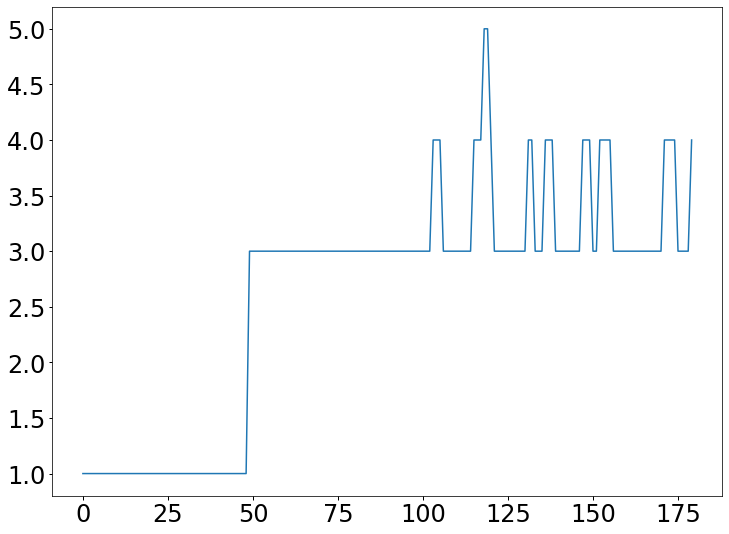

In [222]:
plt.plot(nph)

In [177]:
def compute_coexisting_phases(c,FH,tol=5e-2):
    i=0;
    dist = [];
    nphases =1;
    x0 = []
    all_r = [];
    x0.append(c[0][:-1])
    J_phases = [];
    J_phases.append(FH.jacobian(c[0][:-1],all_flag=False))
    for i in range(0,len(c)):
        r = [];
        for j in range(0,len(x0)):
            r.append(pairwise_dist(c[i][:-1],x0[j]))
        all_r.append(r)
        if(min(r))>tol:
            if (FH.jacobian(c[i][:-1],all_flag=False)>0):
                nphases+=1;
                x0.append(c[i][:-1])
                J_phases.append(FH.jacobian(c[i][:-1],all_flag=False))
    angles = np.zeros((nphases,nphases))
    for i in range(nphases-1):
        for j in range(i+1,nphases):
            vector_p = np.dot(x0[i],x0[j])/(np.linalg.norm(x0[i])*np.linalg.norm(x0[j]))
            angles[i,j] = (np.arccos(vector_p)/np.pi)*180
            angles[j,i] = angles[i,j]
            
    return (nphases,J_phases,angles,x0)

In [193]:
(nphases,J_phases,angles,x0) = compute_coexisting_phases(c0[-1][:,J[-1]>0].T,FH,tol=2.0e-1)

In [194]:
print("number of minima are {} and the concentrations are \n {}".format(nphases,np.matrix(x0)))
print("stability of minima are {} and the angles are \n {}".format(J_phases,np.matrix(angles)))


number of minima are 4 and the concentrations are 
 [[0.0242806  0.02214226 0.76296093]
 [0.65713156 0.04494581 0.05181932]
 [0.04967169 0.62471606 0.06812285]
 [0.01449516 0.81467952 0.0148463 ]]
stability of minima are [2.791473017881158, 0.6262254362234696, 0.12376222682655401, 4.444693292005662] and the angles are 
 [[ 0.         83.57207016 81.99811037 87.26300379]
 [83.57207016  0.         81.12596852 85.00178581]
 [81.99811037 81.12596852  0.          6.24544069]
 [87.26300379 85.00178581  6.24544069  0.        ]]


In [112]:
print(c0[-1][:-1,5,5])
FH.jacobian(c0[-1][:-1,5,5],all_flag=True)

[0.13455772 0.17786381 0.44357767]


(array([[11.53010193,  9.09834717,  9.09834717],
        [ 9.09834717,  9.72062643,  9.09834717],
        [ 9.09834717,  9.09834717,  6.35274381]]),
 array([27.5613939 ,  1.57657624, -1.53449797]),
 array([[ 0.62528148,  0.73676845, -0.25728452],
        [ 0.5832819 , -0.66024368, -0.473139  ],
        [ 0.51846436, -0.14577565,  0.84258184]]))

In [92]:
c0[-3].shape

(4, 64, 64)